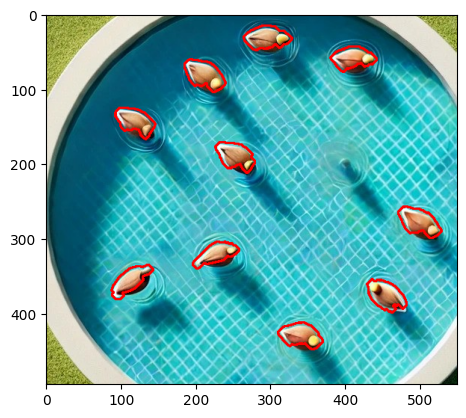

10, 


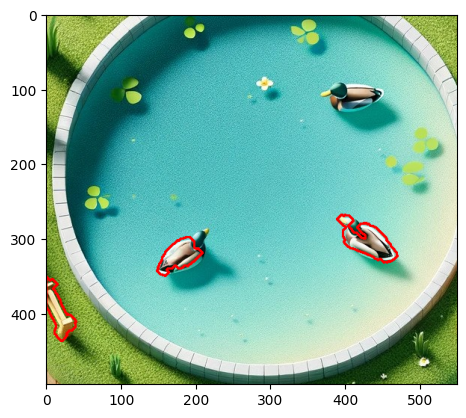

3, 


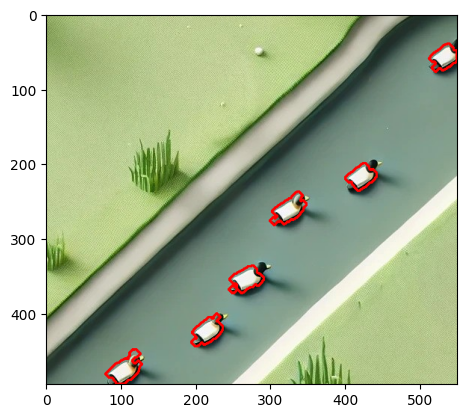

6, 


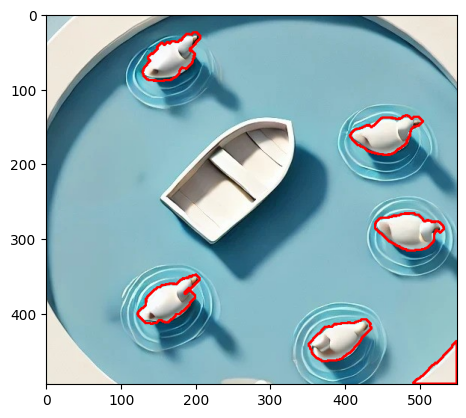

6, 


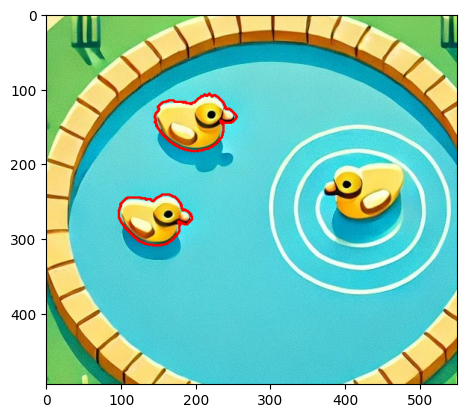

2, 


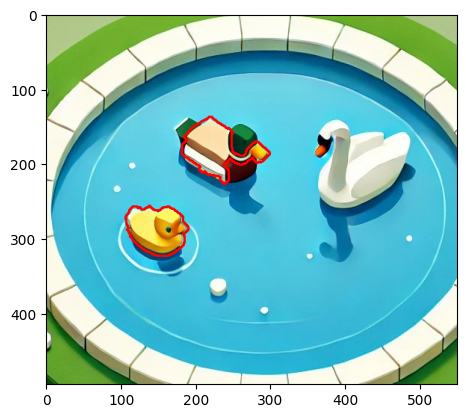

2, 


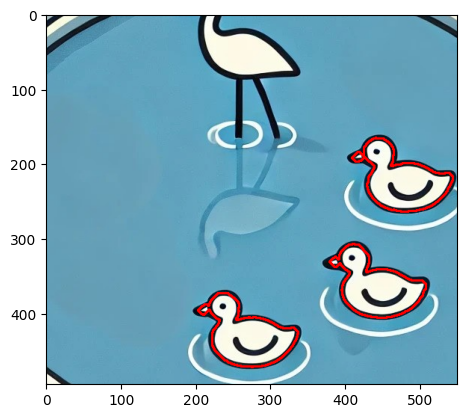

3, 


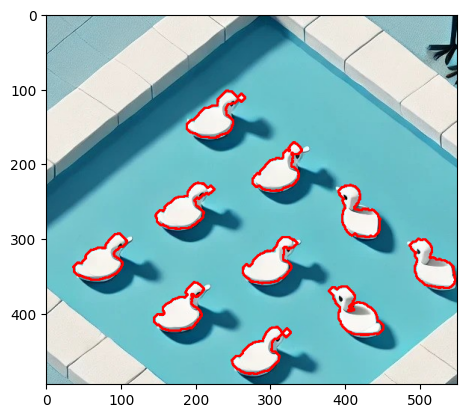

10, 


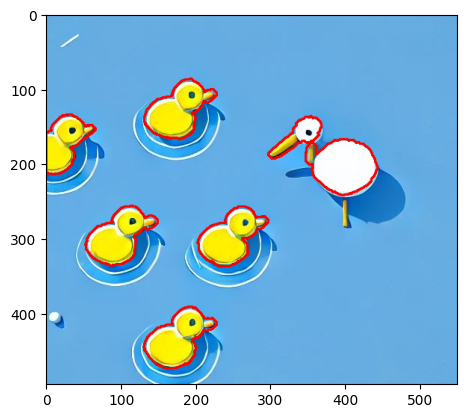

6, 


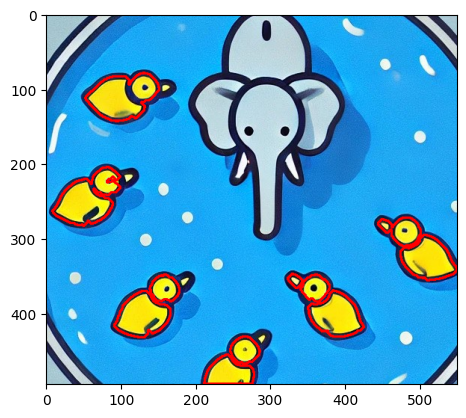

9, 
0.5
True values:  [10  3  6  6  3  2  3 10  5  6]
Prediction:  [10.  3.  6.  6.  2.  2.  3. 10.  6.  9.]


In [ ]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

counted_ducks = np.array([])
number_of_ducks = np.array([10, 3, 6, 6, 3, 2, 3, 10, 5, 6])

# Define the range for green and blue colors to be removed
green_lower = np.array([31, 30, 20], dtype=np.uint8)
green_upper = np.array([85, 255, 255], dtype=np.uint8)
blue_lower = np.array([85, 5, 20], dtype=np.uint8)
blue_upper = np.array([200, 255, 255], dtype=np.uint8)

# Load the folder path from the command line
folder_path = "data"
csv_path = os.path.join(folder_path, "duck_count.csv")
image_data = pd.read_csv(csv_path)

# Load and process images from the CSV file
for index, row in image_data.iterrows():
    image_name = row['picture']
    image_path = os.path.join(folder_path, image_name)

    # Load the image
    img_ducks = cv2.imread(image_path)
    if img_ducks is None:
        print(f"Image {image_name} not found or could not be loaded. Skipping.")
        continue

    # Crop the image
    img_ducks = img_ducks[255:750, 220:770]
    img_original = img_ducks

    # Convert the image to HSV and create masks for green and blue colors
    img_ducks_hsv = cv2.cvtColor(img_ducks, cv2.COLOR_BGR2HSV)
    green_mask = cv2.inRange(img_ducks_hsv, green_lower, green_upper)
    blue_mask = cv2.inRange(img_ducks_hsv, blue_lower, blue_upper)

    # Remove colors using the masks
    img_ducks_hsv[green_mask > 0] = [0, 0, 0]
    img_ducks_hsv[blue_mask > 0] = [0, 0, 0]

    # Convert the image back to RGB
    result_img = cv2.cvtColor(img_ducks_hsv, cv2.COLOR_HSV2BGR)

    # Convert to grayscale
    img_ducks = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    img_ducks_gray = cv2.cvtColor(img_ducks, cv2.COLOR_RGB2GRAY)

    # Binarize the image
    # OTSU gives the best results here
    ret, img_ducks_bin = cv2.threshold(img_ducks_gray, 0, 255, cv2.THRESH_OTSU)  # ret is the threshold value, img_ducks_bin is the binary image

    # Morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

    # Opening operation
    img_ducks_ero = cv2.dilate(img_ducks_bin, kernel, iterations=0)
    img_ducks_open = cv2.erode(img_ducks_ero, kernel, iterations=0)
    # Closing operation
    img_ducks_ero = cv2.erode(img_ducks_open, kernel, iterations=0)
    img_ducks_closed = cv2.dilate(img_ducks_ero, kernel, iterations=5)

    # Find regions (contours)
    contours, hierarchy = cv2.findContours(img_ducks_closed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    img = img_rgb.copy()

    contours_ducks = []  # Store only contours belonging to ducks

    for contour in contours:  # Iterate through each contour
        center, size, angle = cv2.minAreaRect(contour)  # Find the minimum area rectangle enclosing the contour
        height, width = size

        if 30 < width < 100 and 20 < height < 140:  # Condition for the contour to belong to ducks
            contours_ducks.append(contour)

    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    cv2.drawContours(img_original, contours_ducks, -1, (255, 0, 0), 2)
    plt.imshow(img_original)
    plt.show()

    print(f"{len(contours_ducks)}, ")
    counted_ducks = np.append(counted_ducks, len(contours_ducks))

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(number_of_ducks - counted_ducks))
print(mae)
print("True values: ", number_of_ducks)
print("Prediction: ", counted_ducks)
